In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

Make data: sample 75,000 shots from each year. 14 years so 1,050,000 shots. Tee shots excluded since they don't need to be modeled.

In [2]:
for year in range(2003,2017):
    data = pd.read_csv('data/%d.csv' % (year,));
    data = data[data.Shot!=1]
    if year==2003:
        df = data.loc[0:2,:]
    df = df.append(data.iloc[np.random.choice(range(len(data)),size=75000,replace=False)])

/Users/adamlevin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (18,24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['From_Location(Scorer)'].value_counts(dropna=False)

Green                 584237
Fairway               239540
Primary Rough         111048
Green Side Bunker      33951
Intermediate Rough     32612
Fringe                 24747
Fairway Bunker         17025
Native Area             5188
Other                   1519
Water                     79
Grass Bunker              54
Name: From_Location(Scorer), dtype: int64

In [4]:
lr = linear_model.LinearRegression(fit_intercept=False)

In [5]:
cv_mse,results,rsq,prct_std_dev_dec = {},{},{},{}

## Method 0: One big regression with dummies

Specification 0.0- Categories: fairway, rough (with fringe), bunker, green, other

In [6]:
if 'Cat' in df.columns:
    df = df.drop('Cat',axis=1)
df.insert(len(df.columns),'Cat',['Other']*len(df))
df.loc[df['From_Location(Scorer)'] == 'Green','Cat'] = 'Green'
df.loc[df['From_Location(Scorer)'] == 'Fairway','Cat'] = 'Fairway'
df.loc[df['From_Location(Scorer)'].isin(['Primary Rough','Intermediate Rough','Fringe']),'Cat'] = 'Rough'
df.loc[df['From_Location(Scorer)'].isin(['Green Side Bunker','Fairway Bunker']),'Cat'] = 'Bunker'

y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.hstack((x1,x2))

cv_mse['00'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=['Distance']+x2.columns.tolist())
model = sm.OLS(y, X)
results['00'] = model.fit()
rsq['00'] = results['00'].rsquared
prct_std_dev_dec['00'] = (y.std()-results['00'].resid.std())/y.std() * 100

Specification 0.1- Categories: fairway, rough, fringe, bunker, green, other

In [7]:
if 'Cat' in df.columns:
    df = df.drop('Cat',axis=1)
df.insert(len(df.columns),'Cat',['Other']*len(df))
df.loc[df['From_Location(Scorer)'] == 'Green','Cat'] = 'Green'
df.loc[df['From_Location(Scorer)'] == 'Fairway','Cat'] = 'Fairway'
df.loc[df['From_Location(Scorer)'] == 'Fringe','Cat'] = 'Fringe'
df.loc[df['From_Location(Scorer)'].isin(['Primary Rough','Intermediate Rough']),'Cat'] = 'Rough'
df.loc[df['From_Location(Scorer)'].isin(['Green Side Bunker','Fairway Bunker']),'Cat'] = 'Bunker'

y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.hstack((x1,x2))

cv_mse['01'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=['Distance']+x2.columns.tolist())
model = sm.OLS(y, X)
results['01'] = model.fit()
rsq['01'] = results['01'].rsquared
prct_std_dev_dec['01'] = (y.std()-results['01'].resid.std())/y.std() * 100

Specification 0.2- Categories: fairway, intermediate rough, primary rough, fringe, bunker, green, other

In [8]:
if 'Cat' in df.columns:
    df = df.drop('Cat',axis=1)
df.insert(len(df.columns),'Cat',['Other']*len(df))
df.loc[df['From_Location(Scorer)'] == 'Green','Cat'] = 'Green'
df.loc[df['From_Location(Scorer)'] == 'Fairway','Cat'] = 'Fairway'
df.loc[df['From_Location(Scorer)'] == 'Fringe','Cat'] = 'Fringe'
df.loc[df['From_Location(Scorer)'] == 'Primary Rough','Cat'] = 'Primary Rough'
df.loc[df['From_Location(Scorer)' ]== 'Intermediate Rough','Cat'] = 'Intermediate Rough'
df.loc[df['From_Location(Scorer)'].isin(['Green Side Bunker','Fairway Bunker']),'Cat'] = 'Bunker'

y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.hstack((x1,x2))

cv_mse['02'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=['Distance']+x2.columns.tolist())
model = sm.OLS(y, X)
results['02'] = model.fit()
rsq['02'] = results['02'].rsquared
prct_std_dev_dec['02'] = (y.std()-results['02'].resid.std())/y.std() * 100

In [9]:
for ii in sorted(cv_mse):
    print (ii,cv_mse[ii])

('00', 0.30172196377275279)
('01', 0.29918970957600144)
('02', 0.29836082523813345)


In [10]:
for ii in sorted(cv_mse):
    print (ii,rsq[ii])

('00', 0.67991087320916366)
('01', 0.68260817635292059)
('02', 0.6835011610291899)


In [11]:
for ii in sorted(cv_mse):
    print (ii,prct_std_dev_dec[ii])

('00', 43.423479254166274)
('01', 43.662360965926489)
('02', 43.74167000986926)


In [12]:
print results['02'].summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                 8.638e+04
Date:                Fri, 17 Jun 2016   Prob (F-statistic):               0.00
Time:                        13:08:25   Log-Likelihood:            -2.2795e+05
No. Observations:              280000   AIC:                         4.559e+05
Df Residuals:                  279992   BIC:                         4.560e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Distance               0.0018   6.42

Clearly we need seperate distance variable for each category.

## Method 1: Multiply distance times each dummy variable as predictor.

Specification 1.2- Categories: fairway, intermediate rough, primary rough, fringe, bunker, green, other

In [13]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.hstack((x2.values,np.multiply(x2.values,x1)))

cv_mse['12'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=[str(col)+'_I' if u < len(x2.columns) else str(col)+'_D' for u,col in enumerate(x2.columns.tolist()*2)])
model = sm.OLS(y, X)
results['12'] = model.fit()
rsq['12'] = results['12'].rsquared
prct_std_dev_dec['12'] = (y.std()-results['12'].resid.std())/y.std() * 100

In [14]:
for ii in sorted(prct_std_dev_dec):
    print (ii,prct_std_dev_dec[ii])

('00', 43.423479254166274)
('01', 43.662360965926489)
('02', 43.74167000986926)
('12', 50.238031883376024)


In [15]:
print results['12'].summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.752
Method:                 Least Squares   F-statistic:                 6.544e+04
Date:                Fri, 17 Jun 2016   Prob (F-statistic):               0.00
Time:                        13:08:27   Log-Likelihood:            -1.9360e+05
No. Observations:              280000   AIC:                         3.872e+05
Df Residuals:                  279986   BIC:                         3.874e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Bunker_I                 2.4390 

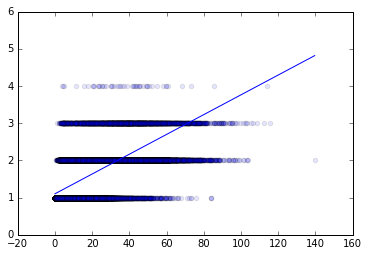

In [16]:
green = df[df['Cat'] == 'Green']
plt.scatter(green.Distance_from_hole.values,green.Shots_taken_from_location.values,alpha=.1)
x = np.array(sorted(green.Distance_from_hole.values.tolist()))
plt.plot(x,1.1024+0.0266*x)

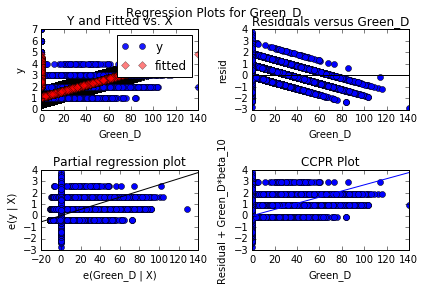

In [17]:
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(results['12'], 'Green_D', fig=fig)

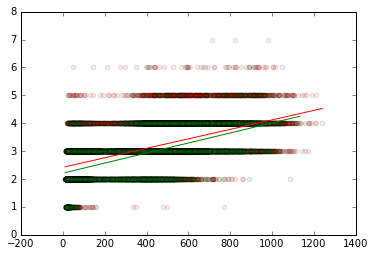

In [18]:
i_rough = df[df['Cat'] == 'Intermediate Rough']
p_rough = df[df['Cat'] == 'Primary Rough']
plt.scatter(p_rough.Distance_from_hole.values,p_rough.Shots_taken_from_location.values,alpha=.1,c='r')
plt.scatter(i_rough.Distance_from_hole.values,i_rough.Shots_taken_from_location.values,alpha=.1,c='g')
x = np.array(sorted(p_rough.Distance_from_hole.values.tolist()))
plt.plot(x,2.4193+0.0017*x,c='r')
x = np.array(sorted(i_rough.Distance_from_hole.values.tolist()))
plt.plot(x,2.2099+0.0018*x,c='g')

## Stage 2: Polynomial Terms

Specification 2.0: Each of the seven categories has its own intercept and own distance, distance^2, and distance^3 variables

In [19]:
def suffix(r):
    if r==0:
        return '_I'
    elif r==1:
        return '_D1'
    elif r==2:
        return '_D2'
    else:
        return '_D3'

In [20]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.array(np.multiply(x2.values,x1))
X_p = np.column_stack((x2.values[:,0],X[:,0],X[:,0]**2,X[:,0]**3))
for c in range(1,X.shape[1]):
    X_p = np.column_stack((X_p,x2.values[:,c],X[:,c],X[:,c]**2,X[:,c]**3))
X = X_p

cv_mse['20'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=[str(col)+suffix(u%4) for u,col in enumerate([col for col in x2.columns.tolist() for _ in range(4)])])
model = sm.OLS(y, X)
results['20'] = model.fit()
rsq['20'] = results['20'].rsquared
prct_std_dev_dec['20'] = (y.std()-results['20'].resid.std())/y.std() * 100

In [21]:
for ii in sorted(prct_std_dev_dec):
    print (ii,cv_mse[ii],rsq[ii],prct_std_dev_dec[ii])

('00', 0.30172196377275279, 0.67991087320916366, 43.423479254166274)
('01', 0.29918970957600144, 0.68260817635292059, 43.662360965926489)
('02', 0.29836082523813345, 0.6835011610291899, 43.74167000986926)
('12', 0.2334787092899536, 0.75237553729224926, 50.238031883376024)
('20', 0.21549743810134245, 0.77152917561059242, 52.2012928669036)


In [22]:
print results['20'].summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 3.502e+04
Date:                Fri, 17 Jun 2016   Prob (F-statistic):               0.00
Time:                        13:08:56   Log-Likelihood:            -1.8233e+05
No. Observations:              280000   AIC:                         3.647e+05
Df Residuals:                  279972   BIC:                         3.650e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Bunker_I                  2.34

In [23]:
rp = results['20'].params

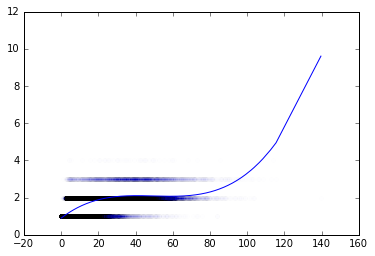

In [24]:
plt.scatter(green.Distance_from_hole.values,green.Shots_taken_from_location.values,alpha=.005)
x = np.array(sorted(green.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Green_I']+rp['Green_D1']*x+rp['Green_D2']*x**2+rp['Green_D3']*x**3)

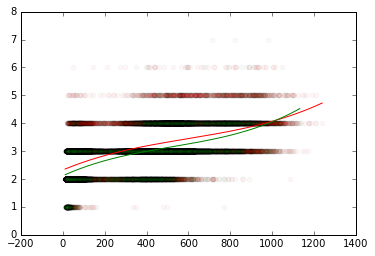

In [25]:
plt.scatter(p_rough.Distance_from_hole.values,p_rough.Shots_taken_from_location.values,alpha=.03,c='r')
plt.scatter(i_rough.Distance_from_hole.values,i_rough.Shots_taken_from_location.values,alpha=.03,c='g')
x = np.array(sorted(p_rough.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Primary Rough_I']+rp['Primary Rough_D1']*x+rp['Primary Rough_D2']*x**2+rp['Primary Rough_D3']*x**3,c='r')
x = np.array(sorted(i_rough.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Intermediate Rough_I']+rp['Intermediate Rough_D1']*x+rp['Intermediate Rough_D2']*x**2+rp['Intermediate Rough_D3']*x**3,c='g')

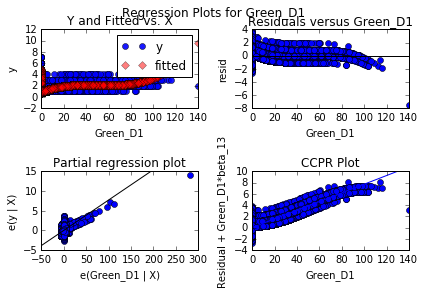

In [26]:
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(results['20'], 'Green_D1', fig=fig)

Specification 2.1: Each of the seven categories has its own intercept and own distance, distance^2, distance^3, distance^4, and distance^5 variables

In [27]:
def suffix(r):
    if r==0:
        return '_I'
    elif r==1:
        return '_D1'
    elif r==2:
        return '_D2'
    elif r==3:
        return '_D3'
    elif r==4:
        return '_D4'
    else:
        return '_D5'

In [28]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.array(np.multiply(x2.values,x1))
X_p = np.column_stack((x2.values[:,0],X[:,0],X[:,0]**2,X[:,0]**3,X[:,0]**4,X[:,0]**5))
for c in range(1,X.shape[1]):
    X_p = np.column_stack((X_p,x2.values[:,c],X[:,c],X[:,c]**2,X[:,c]**3,X[:,c]**4,X[:,c]**5))
X = X_p

cv_mse['21'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=[str(col)+suffix(u%6) for u,col in enumerate([col for col in x2.columns.tolist() for _ in range(6)])])
model = sm.OLS(y, X)
results['21'] = model.fit()
rsq['21'] = results['21'].rsquared
prct_std_dev_dec['21'] = (y.std()-results['21'].resid.std())/y.std() * 100

In [29]:
for ii in sorted(prct_std_dev_dec):
    print (ii,cv_mse[ii],rsq[ii],prct_std_dev_dec[ii])

('00', 0.30172196377275279, 0.67991087320916366, 43.423479254166274)
('01', 0.29918970957600144, 0.68260817635292059, 43.662360965926489)
('02', 0.29836082523813345, 0.6835011610291899, 43.74167000986926)
('12', 0.2334787092899536, 0.75237553729224926, 50.238031883376024)
('20', 0.21549743810134245, 0.77152917561059242, 52.2012928669036)
('21', 0.29321529185411477, 0.70226817562283739, 45.54294499531219)


In [30]:
print results['21'].summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                 1.942e+04
Date:                Fri, 17 Jun 2016   Prob (F-statistic):               0.00
Time:                        13:09:28   Log-Likelihood:            -2.1940e+05
No. Observations:              280000   AIC:                         4.389e+05
Df Residuals:                  279965   BIC:                         4.392e+05
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Bunker_I                  0.00

In [31]:
rp = results['21'].params

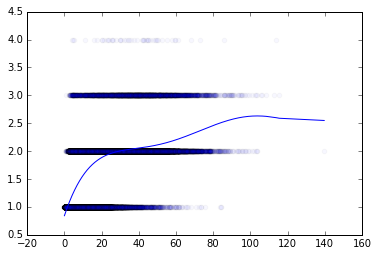

In [32]:
plt.scatter(green.Distance_from_hole.values,green.Shots_taken_from_location.values,alpha=.03)
x = np.array(sorted(green.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Green_I']+rp['Green_D1']*x+rp['Green_D2']*x**2+rp['Green_D3']*x**3+rp['Green_D4']*x**4+rp['Green_D5']*x**5)

(0, 10)

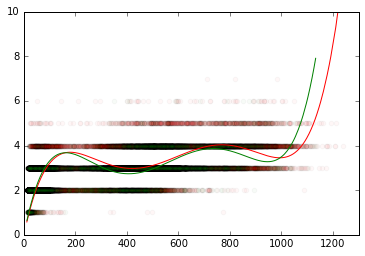

In [33]:
ax = plt.subplot(111)
plt.scatter(p_rough.Distance_from_hole.values,p_rough.Shots_taken_from_location.values,alpha=.03,c='r')
plt.scatter(i_rough.Distance_from_hole.values,i_rough.Shots_taken_from_location.values,alpha=.03,c='g')
x = np.array(sorted(p_rough.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Primary Rough_I']+rp['Primary Rough_D1']*x+rp['Primary Rough_D2']*x**2+rp['Primary Rough_D3']*x**3+rp['Primary Rough_D4']*x**4+rp['Primary Rough_D5']*x**5,c='r')
x = np.array(sorted(i_rough.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Intermediate Rough_I']+rp['Intermediate Rough_D1']*x+rp['Intermediate Rough_D2']*x**2+rp['Intermediate Rough_D3']*x**3+rp['Intermediate Rough_D4']*x**4+rp['Intermediate Rough_D5']*x**5,c='g')
ax.set_xlim([0,1300])
ax.set_ylim([0,10])

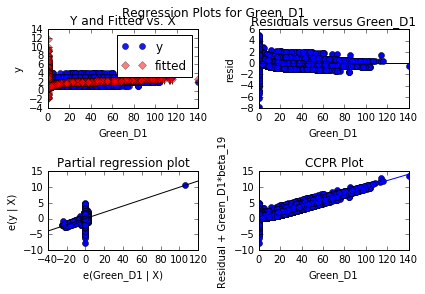

In [34]:
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(results['21'], 'Green_D1', fig=fig)

Specification 2.2: Each of the seven categories has its own intercept and own distance, distance^2, distance^3, distance^4, distance^5, distance^6, and distance^7 variables

In [35]:
def suffix(r):
    if r==0:
        return '_I'
    elif r==1:
        return '_D1'
    elif r==2:
        return '_D2'
    elif r==3:
        return '_D3'
    elif r==4:
        return '_D4'
    elif r==5:
        return '_D5'
    elif r==6:
        return '_D6'
    else:
        return '_D7'

In [36]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.array(np.multiply(x2.values,x1))
X_p = np.column_stack((x2.values[:,0],X[:,0],X[:,0]**2,X[:,0]**3,X[:,0]**4,X[:,0]**5,X[:,0]**6,X[:,0]**7))
for c in range(1,X.shape[1]):
    X_p = np.column_stack((X_p,x2.values[:,c],X[:,c],X[:,c]**2,X[:,c]**3,X[:,c]**4,X[:,c]**5,X[:,c]**6,X[:,c]**7))
X = X_p

cv_mse['22'] = -1*cross_val_score(lr,X,y=y,scoring ='mean_squared_error',cv = 10).mean()

X = pd.DataFrame(X,columns=[str(col)+suffix(u%8) for u,col in enumerate([col for col in x2.columns.tolist() for _ in range(8)])])
model = sm.OLS(y, X)
results['22'] = model.fit()
rsq['22'] = results['22'].rsquared
prct_std_dev_dec['22'] = (y.std()-results['22'].resid.std())/y.std() * 100

In [37]:
for ii in sorted(prct_std_dev_dec):
    print (ii,cv_mse[ii],rsq[ii],prct_std_dev_dec[ii])

('00', 0.30172196377275279, 0.67991087320916366, 43.423479254166274)
('01', 0.29918970957600144, 0.68260817635292059, 43.662360965926489)
('02', 0.29836082523813345, 0.6835011610291899, 43.74167000986926)
('12', 0.2334787092899536, 0.75237553729224926, 50.238031883376024)
('20', 0.21549743810134245, 0.77152917561059242, 52.2012928669036)
('21', 0.29321529185411477, 0.70226817562283739, 45.54294499531219)
('22', 5.4889442052293997, -0.9124618867640073, -0.47560483897674471)


In [38]:
print results['22'].summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.912
Model:                            OLS   Adj. R-squared:                 -0.913
Method:                 Least Squares   F-statistic:                    -5138.
Date:                Fri, 17 Jun 2016   Prob (F-statistic):               1.00
Time:                        13:10:03   Log-Likelihood:            -4.7979e+05
No. Observations:              280000   AIC:                         9.596e+05
Df Residuals:                  279973   BIC:                         9.599e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Bunker_I               1.021e-

In [39]:
rp = results['22'].params

(0, 4)

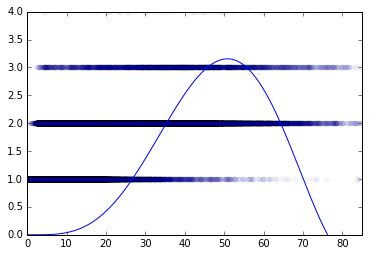

In [40]:
ax = plt.subplot(111)
plt.scatter(green.Distance_from_hole.values,green.Shots_taken_from_location.values,alpha=.03)
x = np.array(sorted(green.Distance_from_hole.values.tolist()))
plt.plot(x,rp['Green_I']+rp['Green_D1']*x+rp['Green_D2']*x**2+rp['Green_D3']*x**3+rp['Green_D4']*x**4+rp['Green_D5']*x**5+rp['Green_D6']*x**6+rp['Green_D7']*x**7)
ax.set_xlim([0,85])
ax.set_ylim([0,4])

Clearly the answer is not adding more polynomial terms of higher degree. In terms of polynomial models, third degree was best. Now on to try some other regression methods.

## Stage 3: Isotonic Regression

In [6]:
if 'Cat' in df.columns:
    df = df.drop('Cat',axis=1)
df.insert(len(df.columns),'Cat',['Other']*len(df))
df.loc[df['From_Location(Scorer)'] == 'Green','Cat'] = 'Green'
df.loc[df['From_Location(Scorer)'] == 'Fairway','Cat'] = 'Fairway'
df.loc[df['From_Location(Scorer)'] == 'Fringe','Cat'] = 'Fringe'
df.loc[df['From_Location(Scorer)'] == 'Primary Rough','Cat'] = 'Primary Rough'
df.loc[df['From_Location(Scorer)' ]== 'Intermediate Rough','Cat'] = 'Intermediate Rough'
df.loc[df['From_Location(Scorer)'].isin(['Green Side Bunker','Fairway Bunker']),'Cat'] = 'Bunker'

In [7]:
y = df.Shots_taken_from_location.values
x1 = np.transpose(np.matrix(df.Distance_from_hole.values))
x2 = pd.get_dummies(df.Cat)
X = np.array(np.multiply(x2.values,x1))

In [7]:
x2.columns

Index([u'Bunker', u'Fairway', u'Fringe', u'Green', u'Intermediate Rough',
       u'Other', u'Primary Rough'],
      dtype='object')

In [8]:
w_v_s = np.zeros(10)
for u,c in enumerate(x2.columns.tolist()):
    y = df.Shots_taken_from_location.values[np.where(X[:,u]!=0)]
    x = X[np.where(X[:,u]!=0)][:,u]
    cv = KFold(n=len(y), n_folds=10)
    ir = IsotonicRegression(out_of_bounds='clip')
    val_scores = []
    for train, test in cv:
        ir.fit(x[train], y[train])
        y_hat = ir.predict(x[test])
        val_scores.append(mean_squared_error(y[test],y_hat))
    w_v_s += np.array(val_scores)*len(y)
print np.mean(w_v_s/len(df))

0.210160505176


          f    t         x
122251  1.0  1.0  0.006739
465121  1.0  1.0  0.007006
468607  1.0  1.0  0.007564
241038  1.0  1.0  0.009910
456878  1.0  1.0  0.010116


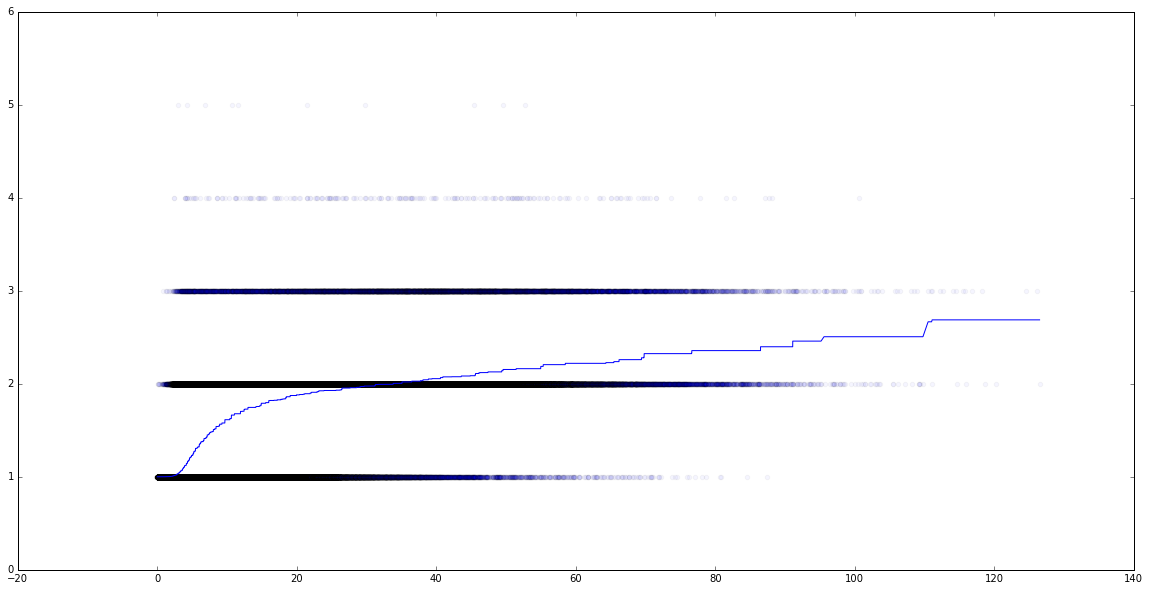

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,3]!=0)]
x = X[np.where(X[:,3]!=0)][:,3]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
print t.head()
plt.scatter(t.x,t.t,alpha=.04)
plt.plot(t.x,t.f)

(1.4, 4.3)

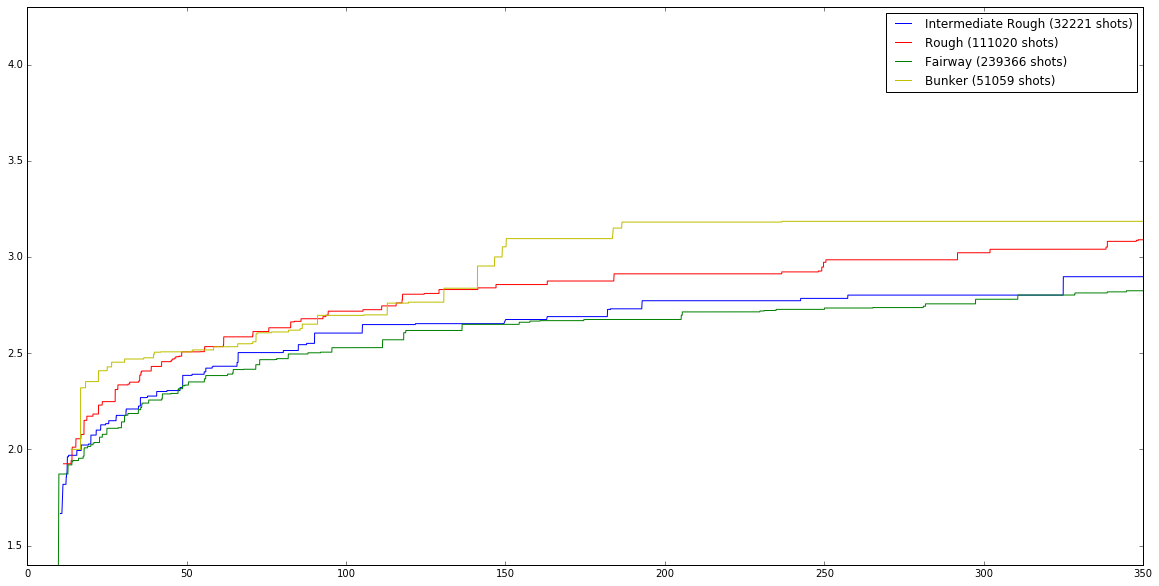

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,4]!=0)]
x = X[np.where(X[:,4]!=0)][:,4]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='b',label='Intermediate Rough (%d shots)' % (len(y),))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,6]!=0)]
x = X[np.where(X[:,6]!=0)][:,6]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='r',label='Rough (%d shots)' % (len(y),))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,1]!=0)]
x = X[np.where(X[:,1]!=0)][:,1]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='g',label='Fairway (%d shots)' % (len(y),))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,0]!=0)]
x = X[np.where(X[:,0]!=0)][:,0]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='y',label='Bunker (%d shots)' % (len(y),))
ax.set_xlim([0,350])
plt.legend()
ax.set_ylim([1.4,4.3])

(0.8, 2.5)

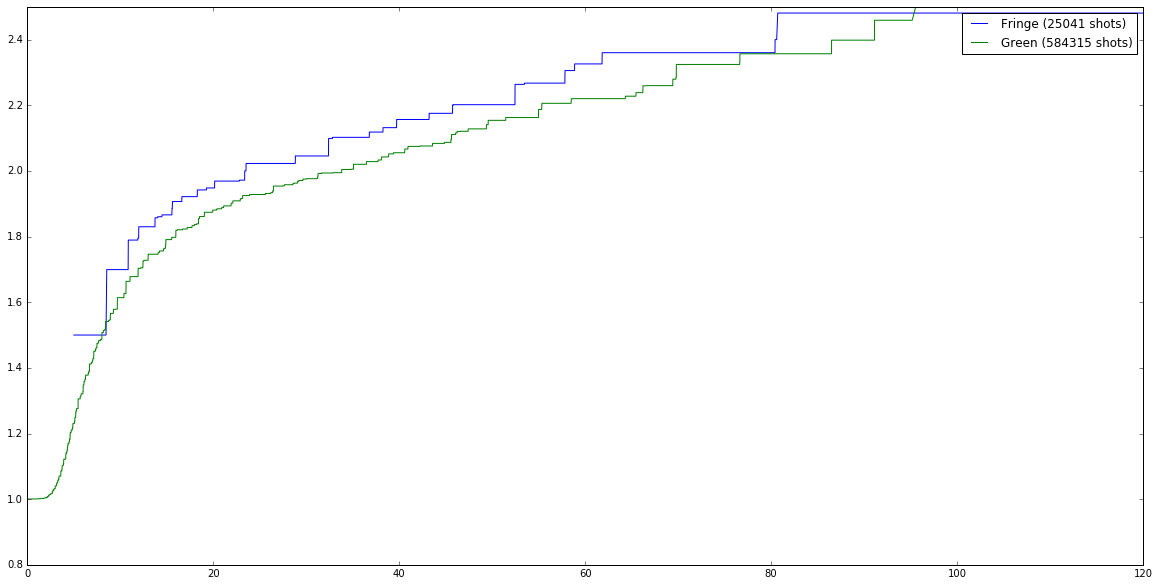

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,2]!=0)]
x = X[np.where(X[:,2]!=0)][:,2]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='b',label='Fringe (%d shots)' % (len(y),))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,3]!=0)]
x = X[np.where(X[:,3]!=0)][:,3]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='g',label='Green (%d shots)' % (len(y),))
plt.legend()
ax.set_xlim([0,120])
ax.set_ylim([.8,2.5])

(0, 1000)

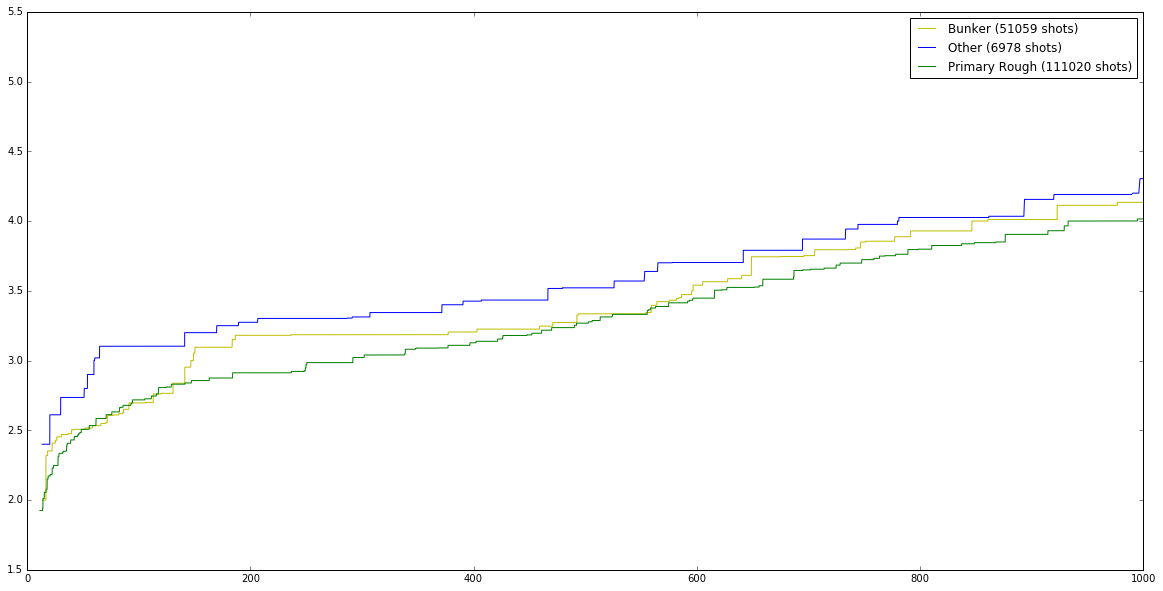

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,0]!=0)]
x = X[np.where(X[:,0]!=0)][:,0]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='y',label='Bunker (%d shots)' % (len(y),))
y = df.Shots_taken_from_location.values[np.where(X[:,5]!=0)]
x = X[np.where(X[:,5]!=0)][:,5]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,label='Other (%d shots)' % (len(y),))
y = df.Shots_taken_from_location.values[np.where(X[:,6]!=0)]
x = X[np.where(X[:,6]!=0)][:,6]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='g',label='Primary Rough (%d shots)' % (len(y),))
plt.legend()
ax.set_xlim([0,1000])

(0.8, 2.5)

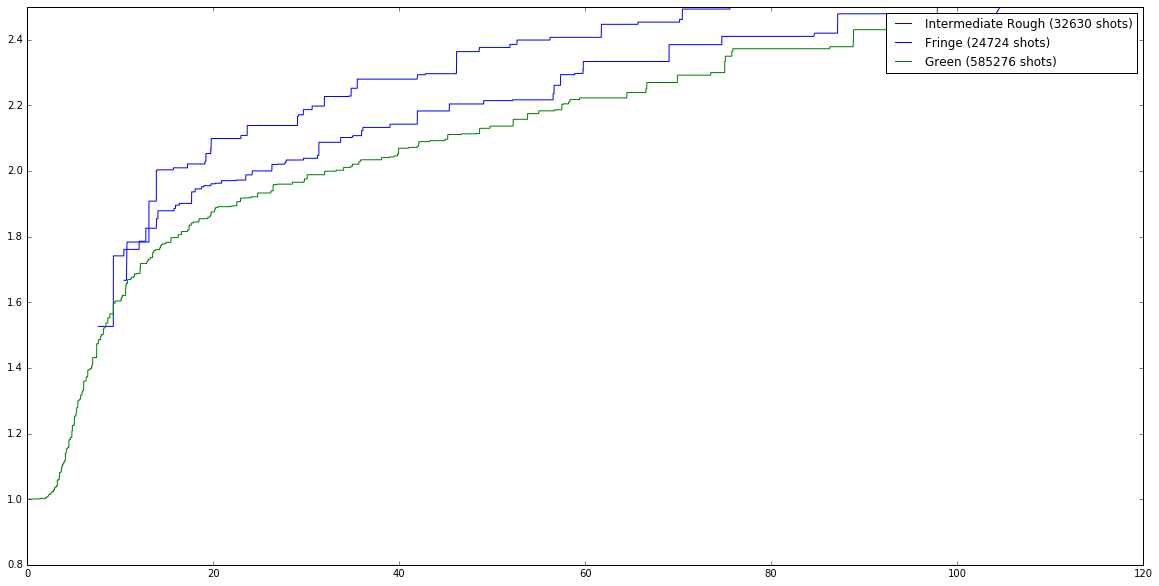

In [8]:
fig, ax = plt.subplots(figsize=(20, 10))

ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,4]!=0)]
x = X[np.where(X[:,4]!=0)][:,4]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='b',label='Intermediate Rough (%d shots)' % (len(y),))

ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,2]!=0)]
x = X[np.where(X[:,2]!=0)][:,2]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='b',label='Fringe (%d shots)' % (len(y),))
ir = IsotonicRegression(out_of_bounds='clip')
y = df.Shots_taken_from_location.values[np.where(X[:,3]!=0)]
x = X[np.where(X[:,3]!=0)][:,3]
ir.fit(x,y)
y_hat = ir.predict(x)
t = pd.DataFrame({'x':x,'t':y,'f':y_hat})
t = t.sort_values('x')
plt.plot(t.x,t.f,c='g',label='Green (%d shots)' % (len(y),))
plt.legend()
ax.set_xlim([0,120])
ax.set_ylim([.8,2.5])

In [3]:
df = df[df['From_Location(Scorer)'] == 'Green']

In [4]:
iso = IsotonicRegression()

In [5]:
iso.fit(df.Distance_from_hole.values,df.Shots_taken_from_location.values);

In [6]:
predictions = iso.predict(df.Distance_from_hole.values)

In [7]:
residuals = predictions-df.Shots_taken_from_location.values

In [8]:
del data

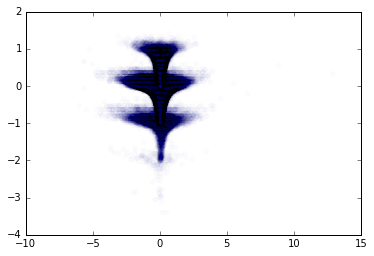

In [11]:
plt.scatter(df.Started_at_Z,residuals,alpha=.01);

In [16]:
X.shape

(584522, 2)

In [20]:
y[:,None].shape

(584522, 1)

In [23]:
X = df.Started_at_Z.values
y = residuals
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     49.40
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           2.09e-12
Time:                        00:03:43   Log-Likelihood:            -1.9817e+05
No. Observations:              584522   AIC:                         3.964e+05
Df Residuals:                  584520   BIC:                         3.964e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.651      0.5

In [24]:
ols = linear_model.LinearRegression()

In [25]:
ols.fit(df.Started_at_Z.values[:,None],residuals);

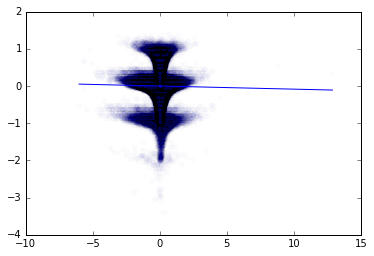

In [26]:
plt.scatter(df.Started_at_Z,residuals,alpha=.01);
plt.plot(np.sort(df.Started_at_Z),ols.predict(np.sort(df.Started_at_Z)[:,None]));

In [30]:
X = np.column_stack([df['Started_at_Z'].values,df['Distance_from_hole'].values * df['Started_at_Z'].values])
y = residuals
X = sm.add_constant(X)

In [31]:
model = sm.OLS(y,X)
results = model.fit()
print results.summary()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     85.09
Date:                Mon, 05 Sep 2016   Prob (F-statistic):           1.12e-37
Time:                        00:10:11   Log-Likelihood:            -1.9811e+05
No. Observations:              584522   AIC:                         3.962e+05
Df Residuals:                  584519   BIC:                         3.963e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.618      0.5